PSNR (host vs hybrid): 38.00 dB


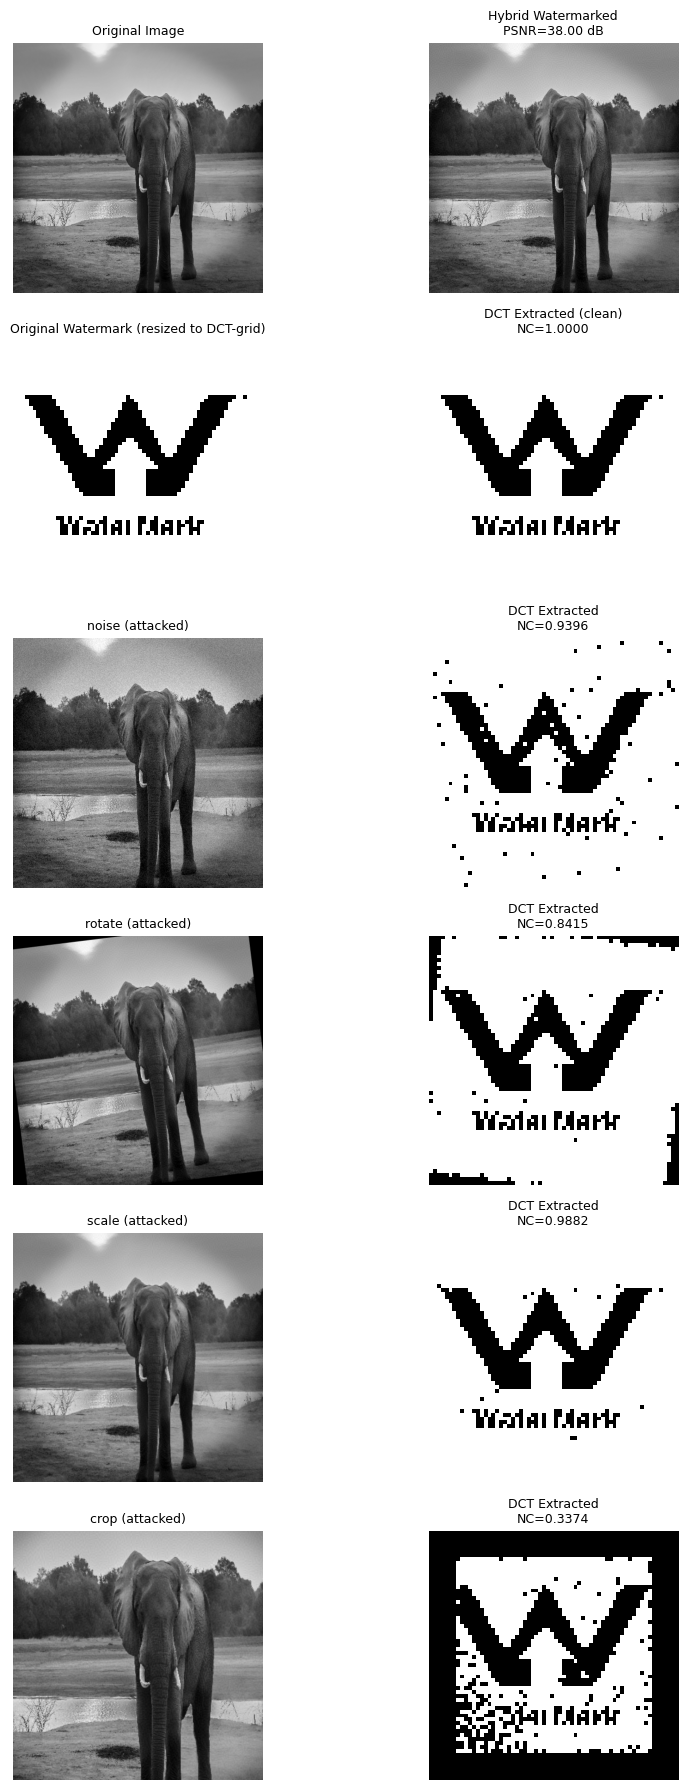


=== Parameter Sweep Complete ===
Best Score: 0.6859
Best combination for balanced robustness, payload, invisibility:
 - Watermark size: (64, 64)
 - alpha_dct: 30
 - alpha_dft: 90
 - PSNR (host vs hybrid): 37.97 dB
 - Avg NC over attacks: 0.8302


In [4]:
# Import Necessary Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# Utilities Functions
def load_gray(path, target_size=None):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {path}")
    if target_size is not None:
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    return img.astype(np.float32)

def show_grid(images, titles, cols=2, figsize=(10,18)):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = plt.subplot(rows, cols, i+1)
        if img.ndim == 2:
            ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        else:
            ax.imshow(img)
        ax.set_title(title, fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def psnr(a, b):
    return compare_psnr(a.astype(np.float64), b.astype(np.float64), data_range=255)

def normalized_correlation(a, b):
    # a and b must be same shape arrays (float). If binary, fine.
    af = a.flatten().astype(np.float64)
    bf = b.flatten().astype(np.float64)
    af -= af.mean()
    bf -= bf.mean()
    num = np.sum(af * bf)
    den = np.sqrt(np.sum(af**2) * np.sum(bf**2)) + 1e-12
    return float(num / den)

# DCT blind embed/extract
MID_BAND_POS = [(0,4),(1,3),(1,4),(2,2),(2,3),(3,1),(3,2),(4,0),(4,1)]

def dct2(block):
    return cv2.dct(block.astype(np.float32))

def idct2(block):
    return cv2.idct(block.astype(np.float32))

def embed_dct_blind(host_img, watermark_bits, alpha=40.0, block_size=8, key=1234):
    h, w = host_img.shape
    bh = h // block_size
    bw = w // block_size
    # watermark_bits expected shape = (bh, bw) or will be resized
    wm = cv2.resize(watermark_bits.astype(np.uint8)*255, (bw, bh), interpolation=cv2.INTER_NEAREST)
    wm = (wm > 127).astype(np.uint8)
    rng = np.random.RandomState(int(key))
    pos_choices = MID_BAND_POS.copy()
    out = np.zeros_like(host_img, dtype=np.float32)
    idx = 0
    for by in range(0, h, block_size):
        for bx in range(0, w, block_size):
            block = host_img[by:by+block_size, bx:bx+block_size]
            if block.shape[0] != block_size or block.shape[1] != block_size:
                padded = np.zeros((block_size, block_size), dtype=block.dtype)
                padded[:block.shape[0], :block.shape[1]] = block
                block = padded
            B = dct2(block - 128.0)
            i1 = rng.randint(0, len(pos_choices))
            i2 = (i1 + 1) % len(pos_choices)
            (u1, v1) = pos_choices[i1]
            (u2, v2) = pos_choices[i2]
            by_idx = idx // bw
            bx_idx = idx % bw
            bit = int(wm[by_idx, bx_idx])
            coeff1 = B[u1, v1]
            coeff2 = B[u2, v2]
            diff = coeff1 - coeff2
            target = alpha if bit == 1 else -alpha
            adjust = (target - diff) / 2.0
            B[u1, v1] += adjust
            B[u2, v2] -= adjust
            idx += 1
            out[by:by+block_size, bx:bx+block_size] = idct2(B) + 128.0
    return np.clip(out, 0, 255).astype(np.float32), {"blocks": (bh, bw), "block_size": block_size, "alpha": alpha, "key": int(key)}

def extract_dct_blind(img, meta, block_size=8, key=1234):
    h, w = img.shape
    bh, bw = meta["blocks"]
    rng = np.random.RandomState(int(key))
    pos_choices = MID_BAND_POS.copy()
    bits = np.zeros((bh, bw), dtype=np.uint8)
    idx = 0
    for by in range(0, h, block_size):
        for bx in range(0, w, block_size):
            block = img[by:by+block_size, bx:bx+block_size]
            if block.shape[0] != block_size or block.shape[1] != block_size:
                padded = np.zeros((block_size, block_size), dtype=block.dtype)
                padded[:block.shape[0], :block.shape[1]] = block
                block = padded
            B = dct2(block - 128.0)
            i1 = rng.randint(0, len(pos_choices))
            i2 = (i1 + 1) % len(pos_choices)
            (u1, v1) = pos_choices[i1]
            (u2, v2) = pos_choices[i2]
            diff = B[u1, v1] - B[u2, v2]
            bit = 1 if diff > 0 else 0
            by_idx = idx // bw
            bx_idx = idx % bw
            if by_idx < bh and bx_idx < bw:
                bits[by_idx, bx_idx] = bit
            idx += 1
    wm_pixels = (bits * 255).astype(np.uint8)
    return wm_pixels, bits

# DFT magnitude embed
def make_annulus_mask(shape, inner_frac=0.05, outer_frac=0.45):
    h, w = shape
    cy, cx = h//2, w//2
    Y, X = np.ogrid[:h, :w]
    R = np.sqrt((Y-cy)**2 + (X-cx)**2)
    max_r = np.sqrt(cx*cx + cy*cy)
    mask = (R >= inner_frac*max_r) & (R <= outer_frac*max_r)
    return mask

def embed_dft_magnitude(host_img, watermark_img, alpha=20.0, inner_frac=0.05, outer_frac=0.45):
    h, w = host_img.shape
    wm_resized = cv2.resize(watermark_img, (w, h), interpolation=cv2.INTER_LINEAR).astype(np.float32)
    wm_norm = (wm_resized - 127.5) / 127.5
    dft = np.fft.fft2(host_img.astype(np.float32))
    dft_shift = np.fft.fftshift(dft)
    magnitude = np.abs(dft_shift)
    phase = np.angle(dft_shift)
    mask = make_annulus_mask((h, w), inner_frac, outer_frac)
    magnitude_mod = magnitude.copy()
    magnitude_mod[mask] += alpha * wm_norm[mask]
    dft_shift_mod = magnitude_mod * np.exp(1j * phase)
    img_back = np.fft.ifft2(np.fft.ifftshift(dft_shift_mod))
    watermarked = np.real(img_back)
    mn, mx = watermarked.min(), watermarked.max()
    watermarked_norm = 255.0 * (watermarked - mn) / (mx - mn + 1e-12)
    metadata = {"orig_magnitude": magnitude, "mask": mask, "alpha": alpha}
    return watermarked_norm.astype(np.float32), metadata

# ORB registration helper (used before DCT extraction)
def register_using_orb(src, dst, nfeatures=1500, good_match_thresh=8):
    src_u8 = np.clip(src,0,255).astype(np.uint8)
    dst_u8 = np.clip(dst,0,255).astype(np.uint8)
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp1, des1 = orb.detectAndCompute(src_u8, None)
    kp2, des2 = orb.detectAndCompute(dst_u8, None)
    if des1 is None or des2 is None or len(kp1) < 8 or len(kp2) < 8:
        return src, False
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    if len(matches) < good_match_thresh:
        return src, False
    pts_src = np.float32([kp1[m.queryIdx].pt for m in matches[:50]]).reshape(-1,1,2)
    pts_dst = np.float32([kp2[m.trainIdx].pt for m in matches[:50]]).reshape(-1,1,2)
    H, status = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 5.0)
    if H is None:
        return src, False
    h, w = dst.shape
    warped = cv2.warpPerspective(src, H, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return warped, True

# Pipeline (hybrid embed, DCT-only extract & display in 6x2 grid)
def hybrid_embedding_dct_only_display(host_path, watermark_path,
                                      target_size=(512,512), wm_size=(64,64),
                                      alpha_dct=60, alpha_dft=40, key=1234):
    # load
    host = load_gray(host_path, target_size=target_size)
    watermark = load_gray(watermark_path, target_size=wm_size)

    h, w = host.shape
    block_size = 8
    bh = h // block_size
    bw = w // block_size
    wm_bits = cv2.resize(watermark, (bw, bh), interpolation=cv2.INTER_NEAREST)
    wm_bits_bin = (wm_bits > 127).astype(np.uint8)

    # DCT blind embedding
    dct_watermarked, dct_meta = embed_dct_blind(host, wm_bits_bin, alpha=alpha_dct, block_size=block_size, key=key)

    # DFT magnitude embedding on top (for hybrid embed)
    dft_watermarked, dft_meta = embed_dft_magnitude(dct_watermarked, watermark, alpha=alpha_dft)

    # hybrid image (visual)
    hybrid = ((dct_watermarked.astype(np.float32) + dft_watermarked.astype(np.float32)) / 2.0).astype(np.uint8)

    # compute PSNR host vs hybrid
    p = psnr(host.astype(np.uint8), hybrid)
    print(f"PSNR (host vs hybrid): {p:.2f} dB")

    # Attacks: noise, rotate, scale, crop
    attacks = {
        "noise": lambda x: np.clip(x + np.random.normal(0, 10, x.shape), 0, 255).astype(np.uint8),
        "rotate": lambda x: cv2.warpAffine(x, cv2.getRotationMatrix2D((x.shape[1]/2, x.shape[0]/2), 7.0, 1.0), (x.shape[1], x.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0),
        "scale": lambda x: cv2.resize(cv2.resize(x, (int(x.shape[1]*0.92), int(x.shape[0]*0.92))), (x.shape[1], x.shape[0])),
        "crop": lambda x: cv2.resize(x[int(0.12*x.shape[0]):int(0.88*x.shape[0]), int(0.12*x.shape[1]):int(0.88*x.shape[1])], (x.shape[1], x.shape[0]))
    }

    # Build images + titles for 6x2 grid (12 images)
    images = []
    titles = []

    # Row 1: original vs hybrid
    images += [host.astype(np.uint8), hybrid]
    titles += ["Original Image", f"Hybrid Watermarked\nPSNR={p:.2f} dB"]

    # Row 2: original watermark (resized to DCT grid for visual) vs DCT-extracted (clean)
    # Extract from clean (try register first)
    reg_clean, ok = register_using_orb(hybrid, host.astype(np.uint8))
    to_extract_clean = reg_clean if ok else hybrid
    extracted_dct_clean_img, extracted_dct_clean_bits = extract_dct_blind(to_extract_clean, dct_meta, block_size=block_size, key=key)
    # Resize extracted DCT image to watermark display size for visualization
    extracted_dct_clean_vis = cv2.resize(extracted_dct_clean_img, watermark.shape[::-1], interpolation=cv2.INTER_NEAREST)
    watermark_vis = cv2.resize(wm_bits_bin.astype(np.uint8)*255, watermark.shape[::-1], interpolation=cv2.INTER_NEAREST)
    # NC between original watermark (resized to DCT grid bits) and extracted bits
    try:
        nc_clean = normalized_correlation((wm_bits_bin*255).astype(np.float32), extracted_dct_clean_img.astype(np.float32))
    except Exception:
        nc_clean = float('nan')

    images += [watermark_vis.astype(np.uint8), extracted_dct_clean_vis.astype(np.uint8)]
    titles += ["Original Watermark (resized to DCT-grid)", f"DCT Extracted (clean)\nNC={nc_clean:.4f}"]

    # Rows 3-6: attacks: attacked image vs extracted DCT (after registration if possible)
    for name, fn in attacks.items():
        attacked = fn(hybrid)
        attacked = attacked.astype(np.uint8)
        # attempt ORB registration to host (helps rotate/scale/crop)
        reg_img, ok = register_using_orb(attacked, host.astype(np.uint8))
        if ok:
            to_extract = reg_img
        else:
            to_extract = attacked
        extracted_dct_img, extracted_dct_bits = extract_dct_blind(to_extract, dct_meta, block_size=block_size, key=key)
        extracted_dct_vis = cv2.resize(extracted_dct_img, watermark.shape[::-1], interpolation=cv2.INTER_NEAREST)
        # compute NC vs original watermark bits (compare bitmaps at DCT grid resolution)
        try:
            nc_val = normalized_correlation((wm_bits_bin*255).astype(np.float32), extracted_dct_img.astype(np.float32))
        except Exception:
            nc_val = float('nan')
        images += [attacked, extracted_dct_vis.astype(np.uint8)]
        titles += [f"{name} (attacked)", f"DCT Extracted\nNC={nc_val:.4f}"]

    # Ensure we have exactly 12 images (6 rows x 2 cols). If less (edge-case), pad with black images.
    while len(images) < 12:
        images.append(np.zeros_like(host, dtype=np.uint8))
        titles.append("")

    # Display full 6x2 grid
    show_grid(images, titles, cols=2, figsize=(10,18))

# Run example
if __name__ == "__main__":
    # change these if needed
    host_path = "watermark_1.jpg"
    watermark_path = "watermark_2images.png"

    hybrid_embedding_dct_only_display(host_path, watermark_path,
                                      target_size=(512,512),
                                      wm_size=(64,64),
                                      alpha_dct=30,
                                      alpha_dft=90)

    import itertools

    # Sweep parameters
    alpha_dct_list = [30, 40, 50, 60]      # DCT strength
    alpha_dft_list = [20, 40, 60, 80,90]      # DFT strength
    wm_size_list = [(32,32), (64,64), (128,128)]  # payload

    best_score = -1
    best_params = None
    results = []

    # weights for scoring: w1=PSNR, w2=robustness, w3=payload
    w1, w2, w3 = 0.4, 0.4, 0.2

    host = load_gray(host_path, target_size=(512,512))
    watermark_orig = load_gray(watermark_path)

    # define attacks
    attacks = [
        lambda x: x,  # clean
        lambda x: np.clip(x + np.random.normal(0, 10, x.shape), 0, 255).astype(np.uint8),  # noise
        lambda x: cv2.warpAffine(x, cv2.getRotationMatrix2D((x.shape[1]/2, x.shape[0]/2), 7.0, 1.0),
                                 (x.shape[1], x.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0),
        lambda x: cv2.resize(cv2.resize(x, (int(x.shape[1]*0.92), int(x.shape[0]*0.92))), (x.shape[1], x.shape[0])),
        lambda x: cv2.resize(x[int(0.12*x.shape[0]):int(0.88*x.shape[0]), int(0.12*x.shape[1]):int(0.88*x.shape[1])],
                             (x.shape[1], x.shape[0]))
    ]

    for wm_sz, a_dct, a_dft in itertools.product(wm_size_list, alpha_dct_list, alpha_dft_list):
        # resize watermark
        wm = cv2.resize(watermark_orig, wm_sz, interpolation=cv2.INTER_NEAREST)
        wm_bits = (wm > 127).astype(np.uint8)

        # DCT embed
        dct_wm, meta = embed_dct_blind(host, wm_bits, alpha=a_dct, block_size=8, key=1234)
        # DFT embed
        dft_wm, _ = embed_dft_magnitude(dct_wm, wm, alpha=a_dft)
        # hybrid
        hybrid = ((dct_wm + dft_wm)/2.0).astype(np.uint8)

        # PSNR for invisibility
        p = psnr(host.astype(np.uint8), hybrid)

        # compute robustness: average NC over attacks
        nc_list = []
        for atk in attacks:
            attacked = atk(hybrid).astype(np.uint8)
            reg_img, ok = register_using_orb(attacked, host.astype(np.uint8))
            to_extract = reg_img if ok else attacked
            extracted_img, _ = extract_dct_blind(to_extract, meta, block_size=8, key=1234)
            try:
                nc_val = normalized_correlation((wm_bits*255).astype(np.float32), extracted_img.astype(np.float32))
            except:
                nc_val = 0.0
            nc_list.append(nc_val)
        avg_nc = np.mean(nc_list)

        # Payload normalized (0-1)
        payload_norm = (wm_sz[0]*wm_sz[1]) / (128*128)

        # Weighted score
        score = w1*(p/50) + w2*avg_nc + w3*payload_norm

        results.append((score, (wm_sz, a_dct, a_dft, p, avg_nc)))
        if score > best_score:
            best_score = score
            best_params = (wm_sz, a_dct, a_dft, p, avg_nc)

    print("\n=== Parameter Sweep Complete ===")
    print(f"Best Score: {best_score:.4f}")
    wm_sz, a_dct, a_dft, psnr_val, nc_val = best_params
    print(f"Best combination for balanced robustness, payload, invisibility:")
    print(f" - Watermark size: {wm_sz}")
    print(f" - alpha_dct: {a_dct}")
    print(f" - alpha_dft: {a_dft}")
    print(f" - PSNR (host vs hybrid): {psnr_val:.2f} dB")
    print(f" - Avg NC over attacks: {nc_val:.4f}")